### Notebook to analyse the results of HS detection on new independant cohort 

In [7]:
import os
import pandas as pd
import numpy as np
import glob


In [93]:
folder = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_independantsite/aidhs_data_folder'

analysis = 'noharmo'  # 'withharmocontrols' ' noharmo'

In [94]:
#sites

if analysis == 'noharmo':
    sites = ['H10','H21','H102','H2','H115', 'H45','H28', 'H5', 'H47', 'H101', 'H14'] # all 3T
    # sites = ['H10','H21','H102','H2'] # restricted to same as harmo
    # sites = ['H19']  # all 15T
elif analysis == 'withharmocontrols':
    sites = ['H10','H21','H102','H2']
elif analysis == '15T':
    sites = ['H19']

#load subjects list
subjects = []
for site in sites:
    subjects_file  = os.path.join(folder, f'list_subjects_{site}.csv')
    subjects_site = pd.read_csv(subjects_file)['ID'].values
    subjects.extend(subjects_site)
len(subjects)

407

In [95]:
#load demographic group for harmonisation
demos_file  = os.path.join(folder,f'demographics_file_{analysis}.csv')

df_demos = pd.read_csv(demos_file)
df_demos.head()

,ID,Site,Scanner,"Patient or Control (Patient = 1, Control = 0)",Age at preoperative,"Sex (Female = 1, Male = 0)"
0,MELD_H2_P_0002,noHarmo,3T,1,13.0,1.0
1,MELD_H2_P_0024,noHarmo,3T,1,4.5,0.0
2,MELD_H2_P_0035,noHarmo,3T,1,16.3,1.0
3,MELD_H2_C_0002,noHarmo,3T,0,9.3,1.0
4,MELD_H2_C_0003,noHarmo,3T,0,7.6,0.0


In [96]:
# load csv with more information
df_info = pd.DataFrame()
for site in sites:
    info_file = glob.glob(os.path.join(folder,f'MELD_participants_infos_{site}_*.csv'))[0]

    df_info_site = pd.read_csv(info_file)
    df_info = pd.concat([df_info,df_info_site])
df_info.head()

,Unnamed: 0,id,old_id,included,reason exlusion,redcap_data_access_group,site,patient_control,sex,radiology,...,participant_information_complete,hemi,reason exclusion,reason_exclusion,field_strengths___unk,field_strengths___na,postop_t1_yr_2___unk,postop_t1_yr_2___na,Unnamed: 1,notes
0,1.0,MELD_H10_P_0001,RMKFDO,1,NaN,NaN,H10,1.0,0.0,1.0,...,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,MELD_H10_P_0002,ARM,1,NaN,NaN,H10,1.0,1.0,8.0,...,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,MELD_H10_P_0003,ELR,1,NaN,NaN,H10,1.0,0.0,8.0,...,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,MELD_H10_P_0004,AAO,1,NaN,NaN,H10,1.0,1.0,10.0,...,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,MELD_H10_P_0005,ADT,1,NaN,NaN,H10,1.0,1.0,10.0,...,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
def transform_bids_id(id):
    ''' convert MELD ID in BIDS ID'''
    id_new = id.split('_')
    id_new = 'sub-'+''.join(id_new)
    return id_new

def get_hippunfold_scores(subject, hippunfold_folder):
        subject_bids = transform_bids_id(subject)
        dices = []
        for hemi in ['L', 'R']:
            file_dice = os.path.join(hippunfold_folder, 'hippunfold', subject_bids, 'qc', f'{subject_bids}_hemi-{hemi}_desc-unetf3d_dice.tsv')
            df_temp = pd.read_csv(file_dice, sep = '\t', header=None)
            dices.append(round(df_temp.values[0][0],2))
        return dices
        

In [98]:

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

hippunfold_folder = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_independantsite/aidhs_data_folder/output/hippunfold_outputs'
results_folder = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_independantsite/aidhs_data_folder/output/prediction_reports'

df_data = pd.DataFrame()

group_array = []
predictions_array = []
labels_array = []
scores_array = []


for subject in subjects:
    print(subject)
    values={}
    values['id'] = subject
    site = df_info[df_info['id']==subject]['site'].values[0]
    folder = site + '_'+ analysis
    group = df_demos[df_demos['ID']==subject]['Patient or Control (Patient = 1, Control = 0)'].values[0]
   #todo : add segmentation scores
    values['seg_score_L'], values['seg_score_R']  = get_hippunfold_scores(subject, hippunfold_folder)
    if group == 1:
        group = 'P'
        hemi = df_info[df_info['id']==subject]['hemi'].values[0]
        if hemi=='L':
            label = 'left HS'
        elif hemi=='R':
            label = 'right HS'
        else:
            print('Hemisphere not known')
    else:
        label = 'no asymmetry'
        group = 'C'
    values['label'] = label
    values['group'] = group
    
    df_results = pd.read_csv(os.path.join(results_folder, folder, subject, f'{subject}_predictions.csv'))
    values['scores']= df_results[['score no asymmetry', 'score left HS', 'score right HS']].values[0]
    values['prediction'] = df_results['prediction'].values[0]

    df_data = pd.concat([df_data, pd.DataFrame([values])])
df_data = df_data.reset_index(drop=True)
df_data.head()

MELD_H10_P_0004
MELD_H10_P_0005
MELD_H10_P_0006
MELD_H10_P_0007
MELD_H10_P_0008
MELD_H10_P_0009
MELD_H10_P_0010
MELD_H10_P_0011
MELD_H10_P_0013
MELD_H10_P_0014
MELD_H10_P_0015
MELD_H10_P_0016
MELD_H10_P_0017
MELD_H10_P_0018
MELD_H10_P_0019
MELD_H10_P_0020
MELD_H10_P_0021
MELD_H10_P_0022
MELD_H10_P_0023
MELD_H10_P_0024
MELD_H10_P_0025
MELD_H10_P_0026
MELD_H10_P_0027
MELD_H10_P_0028
MELD_H10_P_0029
MELD_H10_P_0030
MELD_H10_P_0031
MELD_H10_P_0032
MELD_H10_P_0033
MELD_H10_P_0034
MELD_H10_P_0035
MELD_H10_P_0036
MELD_H10_P_0037
MELD_H10_P_0038
MELD_H10_P_0039
MELD_H10_P_0040
MELD_H10_P_0041
MELD_H10_P_0042
MELD_H10_P_0043
MELD_H10_P_0044
MELD_H10_P_0045
MELD_H10_P_0046
MELD_H10_P_0047
MELD_H10_P_0049
MELD_H10_P_0050
MELD_H10_P_0051
MELD_H10_P_0052
MELD_H10_P_0053
MELD_H10_P_0054
MELD_H10_P_0055
MELD_H10_P_0056
MELD_H10_P_0057
MELD_H10_P_0058
MELD_H10_P_0059
MELD_H10_C_0001
MELD_H10_C_0002
MELD_H10_C_0003
MELD_H10_C_0004
MELD_H10_C_0005
MELD_H10_C_0006
MELD_H10_C_0007
MELD_H10_C_0008
MELD_H10

,id,seg_score_L,seg_score_R,label,group,scores,prediction
0,MELD_H10_P_0004,0.81,0.81,left HS,P,"[0.0215204251794011, 0.9784789587158396, 6.161...",left HS
1,MELD_H10_P_0005,0.66,0.82,left HS,P,"[2.627524919347693e-05, 0.9999737247508044, 2....",left HS
2,MELD_H10_P_0006,0.80,0.79,right HS,P,"[0.1175017048303757, 0.0003901297523548, 0.882...",right HS
3,MELD_H10_P_0007,0.80,0.80,right HS,P,"[0.0008068016112499, 3.429433596082658e-08, 0....",right HS
4,MELD_H10_P_0008,0.65,0.82,left HS,P,"[0.0132537558380525, 0.9867462424816046, 1.680...",left HS


In [62]:
# df_data.to_csv(f'/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_independantsite/aidhs_data_folder/list_subjects_study_{analysis}.csv')

In [99]:
# analyse how many have segmentation scores below 0.7

df_data[(df_data['seg_score_L']<0.7) | (df_data['seg_score_R']<0.7)]

,id,seg_score_L,seg_score_R,label,group,scores,prediction
1,MELD_H10_P_0005,0.66,0.82,left HS,P,"[2.627524919347693e-05, 0.9999737247508044, 2....",left HS
4,MELD_H10_P_0008,0.65,0.82,left HS,P,"[0.0132537558380525, 0.9867462424816046, 1.680...",left HS
6,MELD_H10_P_0010,0.69,0.74,left HS,P,"[0.0180444617137413, 0.981955372881158, 1.6540...",left HS
29,MELD_H10_P_0034,0.83,0.65,right HS,P,"[3.5136151147889507e-06, 1.2793428336850011e-1...",right HS
47,MELD_H10_P_0053,0.35,0.81,left HS,P,"[0.6946768354483007, 0.3053231520145201, 1.253...",no asymmetry
91,MELD_H10_C_0040,0.69,0.66,no asymmetry,C,"[0.6734456256717751, 0.3106874492866577, 0.015...",no asymmetry
109,MELD_H21_P_0170,0.76,0.68,right HS,P,"[0.1158443354020125, 0.0001331810847326, 0.884...",right HS
118,MELD_H21_P_0056,0.71,0.47,no asymmetry,C,"[0.00033121821094, 4.695115419031049e-09, 0.99...",right HS
121,MELD_H21_P_0064,0.03,0.11,no asymmetry,C,"[4.771638765268104e-05, 0.999952283255896, 3.5...",left HS
123,MELD_H21_P_0066,0.68,0.71,no asymmetry,C,"[0.7898708755323824, 0.192587337217734, 0.0175...",no asymmetry


(array([  2.,   0.,   0.,   0.,   1.,   0.,   1.,   3.,  12., 136.]),
 array([0.11 , 0.184, 0.258, 0.332, 0.406, 0.48 , 0.554, 0.628, 0.702,
        0.776, 0.85 ]),
 <BarContainer object of 10 artists>)

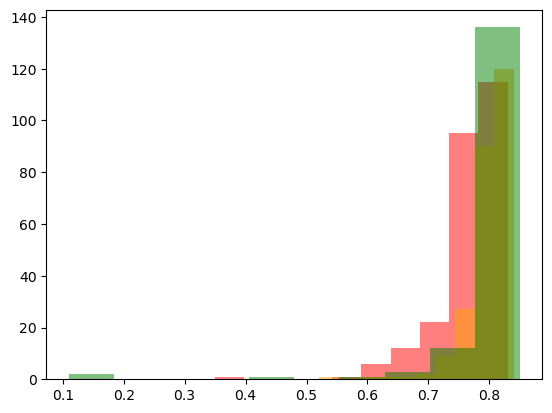

In [100]:
# plot segmentation scores in ipsi - contra - controls
import matplotlib.pyplot as plt
import random

ipsi_scores = list(df_data[(df_data['label']=='left HS')]['seg_score_L'].values) + list(df_data[(df_data['label']=='right HS')]['seg_score_R'].values)
contra_scores = list(df_data[(df_data['label']=='left HS')]['seg_score_R'].values) + list(df_data[(df_data['label']=='right HS')]['seg_score_L'].values)
controls_scores = list(df_data[(df_data['label']=='no asymmetry')]['seg_score_L'].values) + list(df_data[(df_data['label']=='no asymmetry')]['seg_score_R'].values)
controls_scores = random.sample(controls_scores, round(len(controls_scores)/2))


plt.hist(ipsi_scores, color='red', alpha=0.5)
plt.hist(contra_scores, color='orange', alpha=0.5)
plt.hist(controls_scores, color='green', alpha=0.5)


In [101]:
## remove outliers from QC
print(len(df_data))
subjects_excluded  = pd.read_csv('/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_independantsite/aidhs_data_folder/subjects_discarded_QC.csv')
subjects_excluded = subjects_excluded[subjects_excluded['discard']==1]['ID'].values
print(subjects_excluded)

df_data = df_data[~df_data['id'].isin(subjects_excluded)]
print(len(df_data))

407
['MELD_H10_P_0053' 'MELD_H21_P_0056' 'MELD_H21_P_0064' 'MELD_H21_P_0073'
 'MELD_H2_P_0002']
402


In [102]:
# Encode data class and prediction
import numpy as np
from sklearn.preprocessing import label_binarize

dict_labels = {'no asymmetry':0,
               'left HS':1,
               'right HS':2}
Y = np.array([dict_labels[x] for x in df_data['label'].values])
y_pred = np.array([dict_labels[x] for x in df_data['prediction'].values])
scores =  np.array([x for x in df_data['scores']])

#Binarize the output
y_bin = label_binarize(Y, classes=np.arange(len(set(Y))))

print('number ipsi lh: ' + str(len(np.where(Y==1)[0])))
print('number ipsi rh: ' + str(len(np.where(Y==2)[0])))
print('number control: ' + str(len(np.where(Y==0)[0])))


number ipsi lh: 142
number ipsi rh: 108
number control: 152


In [103]:
# compute results lateralisation and detection
from aidhs.train_evaluate import compute_performances, get_lateralisation_performances, get_differentiation_performances

#COMPUTE PERFORMANCES
results = compute_performances(Y, y_bin, y_pred, scores)
    
#add lateralisation performances
results['predict_side'], results['accurately_lateralised'], results['scores_lateralised'] = get_lateralisation_performances(Y, scores)

#add detection performances
results['predict_group'], results['accurately_differentiated'], results['scores_differentiated'] = get_differentiation_performances(Y, scores)
    

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       152
           1       0.98      0.87      0.92       142
           2       0.93      0.93      0.93       108

    accuracy                           0.91       402
   macro avg       0.92      0.91      0.92       402
weighted avg       0.92      0.91      0.91       402



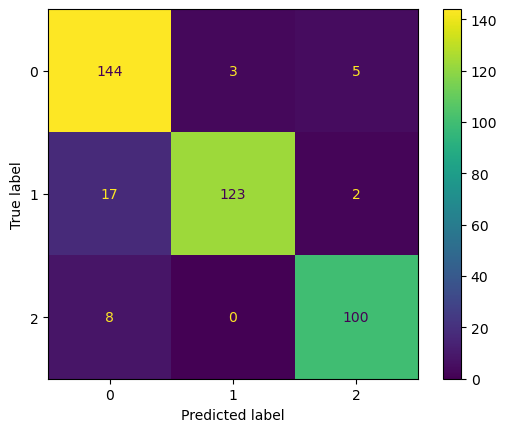

In [104]:
# plot confusion matrix
print(classification_report(Y,results['predictions']))
cm = confusion_matrix(Y,results['predictions'])
ConfusionMatrixDisplay(cm).plot()

In [105]:
#comparison of overall performances per methods

try:
    print('\nPerformances lateralisation only:')
    df_data[f'TP_side'] = results['accurately_lateralised']
    
    n_tot = len(df_data[(df_data['group']=='P')])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['TP_side']==True)])
        print(f'TP in HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

except:
    pass

try:
    print('\nPerformances differentiation only:')
    df_data[f'TP_group'] = results['accurately_differentiated']

    n_tot = len(df_data)
    if n_tot>0:
        n_tp = len(df_data[(df_data['TP_group']==True)])
        print(f'TP differentiating: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[df_data['group']!='P'])
    if n_tot>0:
        n_tp = len(df_data[(df_data['group']!='P')&(df_data['TP_group']==True)])
        print(f'TP detecting controls: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[(df_data['group']=='P')])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['TP_group']==True)])
        print(f'TP detecting HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass


Performances lateralisation only:
TP in HS: 242/250 (96.8%)

Performances differentiation only:
TP differentiating: 369/402 (91.8%)
TP detecting controls: 144/152 (94.7%)
TP detecting HS: 225/250 (90.0%)


In [106]:
#breakdown per site

#combine df_data with site
df_data['site'] = [df_info[df_info['id']==subject]['site'].values[0] for subject in df_data['id']]

#print performances per site
print('\nPerformances lateralisation only:')
df_data[f'TP_side'] = results['accurately_lateralised']
for site in sites:
    n_tot = len(df_data[(df_data['group']=='P')&(df_data['site']==site)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['site']==site)&(df_data['TP_side']==True)])
        print(f'TP lateralising {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


print('\nPerformances differentiation only:')
df_data[f'TP_group'] = results['accurately_differentiated']
        
for site in sites:
    n_tot = len(df_data[(df_data['group']=='P')&(df_data['site']==site)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['site']==site)&(df_data['TP_group']==True)])
        print(f'TP detecting patients {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    
    n_tot = len(df_data[(df_data['group']=='C')&(df_data['site']==site)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='C')&(df_data['site']==site)&(df_data['TP_group']==True)])
        print(f'TP detecting controls {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


Performances lateralisation only:
TP lateralising H10: 52/53 (98.1%)
TP lateralising H21: 3/3 (100.0%)
TP lateralising H102: 5/5 (100.0%)
TP lateralising H2: 2/2 (100.0%)
TP lateralising H115: 3/3 (100.0%)
TP lateralising H45: 2/2 (100.0%)
TP lateralising H28: 2/2 (100.0%)
TP lateralising H5: 144/149 (96.6%)
TP lateralising H47: 29/31 (93.5%)

Performances differentiation only:
TP detecting patients H10: 48/53 (90.6%)
TP detecting controls H10: 53/54 (98.1%)
TP detecting patients H21: 2/3 (66.7%)
TP detecting controls H21: 13/17 (76.5%)
TP detecting patients H102: 5/5 (100.0%)
TP detecting controls H102: 21/21 (100.0%)
TP detecting patients H2: 2/2 (100.0%)
TP detecting controls H2: 19/20 (95.0%)
TP detecting patients H115: 3/3 (100.0%)
TP detecting patients H45: 2/2 (100.0%)
TP detecting patients H28: 2/2 (100.0%)
TP detecting patients H5: 132/149 (88.6%)
TP detecting patients H47: 29/31 (93.5%)
TP detecting controls H101: 19/20 (95.0%)
TP detecting controls H14: 19/20 (95.0%)


In [107]:
#breakdown per mri-neg

#combine df_data with mri negative
df_data['mri_neg'] = [df_info[df_info['id']==subject]['mri_negative'].values[0] for subject in df_data['id']]

try:
    print('\nPerformances lateralisation only:')
    df_data[f'TP_side'] = results['accurately_lateralised']
    
    n_tot = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==1.0)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==1.0)&(df_data['TP_side']==True)])
        print(f'TP in MRI negative HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    
    n_tot = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==0.0)])
    if n_tot>0:
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==0.0)&(df_data['TP_side']==True)])
        print(f'TP in MRI positive HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass

try:
    print('\nPerformances differentiation only:')
    df_data[f'TP_group'] = results['accurately_differentiated']

    n_tot = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==1.0)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==1.0)&(df_data['TP_group']==True)])
        print(f'TP detecting MRI negative HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==0.0)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['mri_neg']==0.0)&(df_data['TP_group']==True)])
        print(f'TP detecting MRI positive HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass


Performances lateralisation only:
TP in MRI negative HS: 8/14 (57.1%)
TP in MRI positive HS: 232/234 (99.1%)

Performances differentiation only:
TP detecting MRI negative HS: 3/14 (21.4%)
TP detecting MRI positive HS: 220/234 (94.0%)


In [109]:
#breakdown per seizure freedom

#combine df_data with mri negative
df_data['seizure_free'] = [df_info[df_info['id']==subject]['seizure_free'].values[0] for subject in df_data['id']]


try:
    print('\nPerformances lateralisation only:')
    df_data[f'TP_side'] = results['accurately_lateralised']
    
    df_sub = df_data.dropna(subset=['seizure_free'])

    n_tot = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==1)])
    if n_tot>0:   
        n_tp = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==1)&(df_sub['TP_side']==True)])
        print(f'TP in seizure free: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    
    n_tot = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==2)])
    if n_tot>0:
        n_tp = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==2)&(df_sub['TP_side']==True)])
        print(f'TP in not seizure free: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass

try:
    print('\nPerformances differentiation only:')
    df_data[f'TP_group'] = results['accurately_differentiated']
    
    df_sub = df_data.dropna(subset=['seizure_free'])
    
    n_tot = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==1)])
    if n_tot>0:   
        n_tp = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==1)&(df_sub['TP_group']==True)])
        print(f'TP in seizure free: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    
    n_tot = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==2)])
    if n_tot>0:
        n_tp = len(df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==2)&(df_sub['TP_group']==True)])
        print(f'TP in not seizure free: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass


Performances lateralisation only:
TP in seizure free: 153/155 (98.7%)
TP in not seizure free: 88/94 (93.6%)

Performances differentiation only:
TP in seizure free: 142/155 (91.6%)
TP in not seizure free: 82/94 (87.2%)


In [90]:
df_sub[(df_sub['group']=='P')&(df_sub['seizure_free']==1) & (df_sub['TP_side']==True)]

,id,seg_score_L,seg_score_R,label,group,scores,prediction,TP_side,TP_group,site,mri_neg,seizure_free
0,MELD_H10_P_0004,0.81,0.81,left HS,P,"[0.0215204251794011, 0.9784789587158396, 6.161...",left HS,True,True,H10,0.0,1.0
2,MELD_H10_P_0006,0.80,0.79,right HS,P,"[0.1175017048303757, 0.0003901297523548, 0.882...",right HS,True,True,H10,0.0,1.0
4,MELD_H10_P_0008,0.65,0.82,left HS,P,"[0.0132537558380525, 0.9867462424816046, 1.680...",left HS,True,True,H10,0.0,1.0
7,MELD_H10_P_0011,0.75,0.73,left HS,P,"[0.8228553244718471, 0.1452140287762987, 0.031...",no asymmetry,True,False,H10,0.0,1.0
8,MELD_H10_P_0013,0.76,0.80,left HS,P,"[0.0052147691964878, 0.9947852247720358, 6.031...",left HS,True,True,H10,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
329,MELD_H5_P_0441,0.77,0.78,left HS,P,"[0.0025698688658661, 0.9974301210593584, 1.007...",left HS,True,True,H5,0.0,1.0
331,MELD_H5_P_0444,0.81,0.83,left HS,P,"[0.0531626039891219, 0.9468238156740386, 1.358...",left HS,True,True,H5,0.0,1.0
332,MELD_H5_P_0447,0.76,0.76,right HS,P,"[0.0001537842412343, 2.289952929991988e-08, 0....",right HS,True,True,H5,0.0,1.0
333,MELD_H5_P_0452,0.80,0.79,left HS,P,"[0.0038257319784396, 0.9961742581944038, 9.827...",left HS,True,True,H5,0.0,1.0


In [88]:
n_tot

86

In [21]:
df_info.keys()

Index(['Unnamed: 0', 'id', 'old_id', 'included', 'reason exlusion',
       'redcap_data_access_group', 'site', 'patient_control', 'sex',
       'radiology', 'radiology_report', 'field_strengths___1',
       'field_strengths___2', 'field_strengths___3', 'age_at_preop_t1_15t',
       'age_at_preop_t1_3t', 'age_at_preop_t1_7t', 'preop_t1_yr_15t',
       'preop_t1_yr_3t', 'preop_t1_yr_7t', 'postop_t1_yr',
       'postop_t1_yr_2___1', 'postop_t1_yr_2___2', 'postop_t1_yr_2___3',
       'control_headache', 'preop_t1', 'preop_t2', 'preop_flair', 'preop_dwi',
       'postop_t1', 'fields', 'lesion_mask', 'age_at_onset', 'gtcs',
       'drug_resistant', 'aeds', 'mri_negative', 'seeg', 'operated',
       'surgery_year', 'age_at_surgery', 'mri_negative_surgery', 'procedure',
       'procedure_other', 'histology', 'histology_other', 'seizure_free',
       'seizure_free_aura', 'engel_1yr', 'ilae_1yr', 'engel', 'ilae',
       'follow_up', 'aeds_post_op', 'participant_information_complete', 'hemi',
   

In [22]:
df_info[df_info['id']=='MELD_H10_P_0045']

,Unnamed: 0,id,old_id,included,reason exlusion,redcap_data_access_group,site,patient_control,sex,radiology,...,participant_information_complete,hemi,reason exclusion,reason_exclusion,field_strengths___unk,field_strengths___na,postop_t1_yr_2___unk,postop_t1_yr_2___na,Unnamed: 1,notes
44,45.0,MELD_H10_P_0045,NCF,1,NaN,NaN,H10,1.0,0.0,10.0,...,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
